#### 数据集定义

In [1]:
import cv2
import csv
from matplotlib import pyplot as plt
import numpy as np
## AASCE2019
path = "D:/Project/Xiehe_Spinal_image_stitching/cobb/ke30_u7_AASCE2019-master/boostnet_labeldata" # 数据集路径
landmarks = csv.reader(open(path + "/labels/training/landmarks.csv", 'r')) #关键点坐标
names= csv.reader(open(path + "/labels/training/filenames.csv", 'r')) # 图像文件名
image_path = path + "/data/training_preprocessed/" # 图像路径
## 全长像
# landmarks =  csv.reader(open(r"D:\Project\Xiehe_Spinal_image_stitching\cobb\labeled_spine\landmarks_test.csv", 'r'))
# names = csv.reader(open(r"D:\Project\Xiehe_Spinal_image_stitching\cobb\labeled_spine\filenames_test.csv", 'r'))
# image_path = r"D:\Project\Xiehe_Spinal_image_stitching\cobb\Full_length_img\test/"

names=list(names) # 将names转换为列表
names=[image_path+n[0] for n in names] # 将图像路径和文件名拼接起来
labels=[] # 存储关键点坐标【y,x】
for landmark_each_image in landmarks:#地标
    coordinate_list = []
    for coordinate in landmark_each_image:
        coordinate_list.append(float(coordinate))
        # print(coordinate_list)
    labels.append(coordinate_list)
num_p=len(labels[0])//2

#### 通过解析点坐标之间的斜率直接计算cob角

Maximum Tilted vertebra 6 11


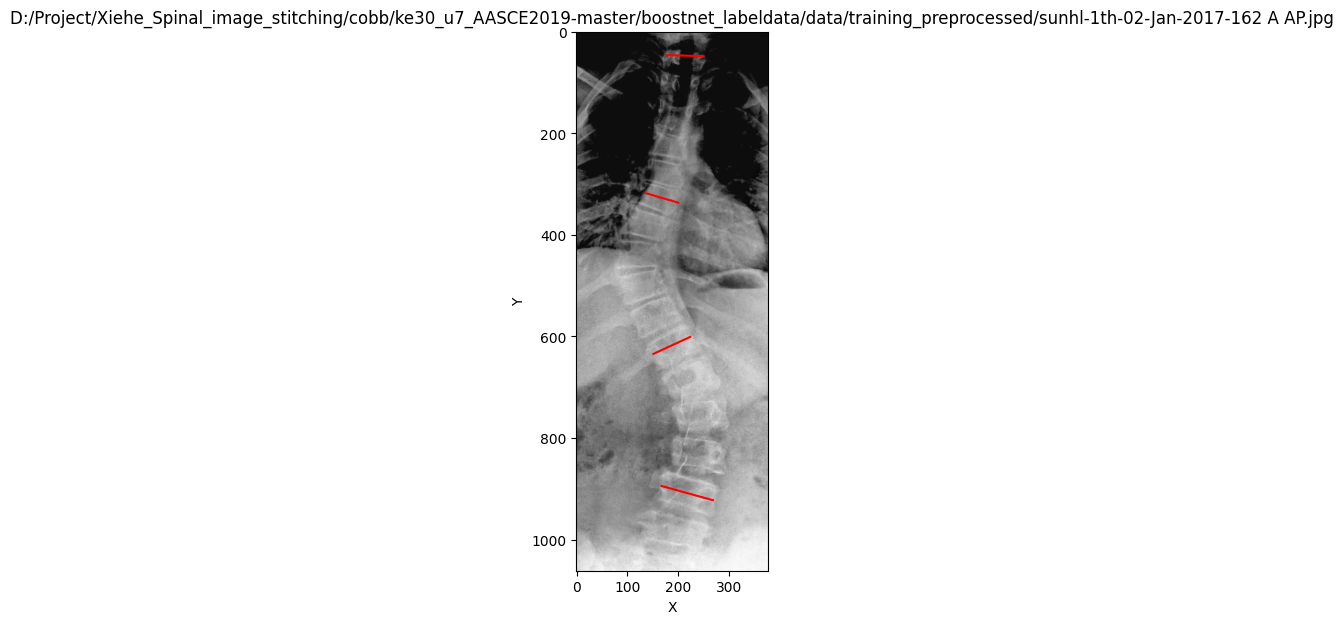

 Cobb angles [41.503346970970576, 14.744389106368054, 40.43137528782779]


In [2]:
idx = 0
p=labels[idx]
num_p = len(p)//2
img = cv2.imread(names[idx])
img = cv2.resize(img,(int(img.shape[1]/2),int(img.shape[0]/2)))
img_c=img.copy()
h,w=img.shape[:2]

slopes =[]
avg_slopes=[]
lines = []
c_lines = []
cobb_angles= [0.0,0.0,0.0]
for m in range (0,num_p,2):
    slope = ((img.shape[0]*p[m+1+num_p])-(img.shape[0]*p[m+num_p]))/((img.shape[1]*p[m+1])-(img.shape[1]*p[m]))#计算每两对点之间的斜率
    #print (p[m+num_p])
    slopes.append(slope)
    lines.append((((img.shape[1]*p[m+1]),(img.shape[0]*p[m+1+num_p])),((img.shape[1]*p[m]),(img.shape[0]*p[m+num_p]))))#连线(x1,y1),(x2,y2)

for s in range (0,num_p//2,2):
    avg_slopes.append((slopes[s]+slopes[s+1])/2)#每个椎体的平均斜率
    p0_L=lines[s][0]
    p0_R=lines[s][1]
    p1_L=lines[s+1][0]
    p1_R=lines[s+1][1]
    pc_L=((p0_L[0]+p1_L[0])/2,(p0_L[1]+p1_L[1])/2)
    pc_R=((p0_R[0]+p1_R[0])/2,(p0_R[1]+p1_R[1])/2)
    c_lines.append(((pc_L),(pc_R)))

avg_slope = np.array(avg_slopes)
max_slope = np.amax(avg_slopes)
min_slope= np.amin(avg_slopes)
if np.argmax(avg_slopes[1:num_p//4 - 1])> np.argmin(avg_slopes[1:num_p//4 - 1]):#两种情况：左弯或者右弯
    lower_MT= np.argmax(avg_slopes[1:num_p//4 - 1]) + 1
    upper_MT = np.argmin(avg_slopes[1:num_p//4 - 1]) + 1
    
else:
    upper_MT= np.argmax(avg_slopes[1:num_p//4 - 1]) + 1#斜率为正在上脊柱
    lower_MT = np.argmin(avg_slopes[1:num_p//4 - 1]) + 1#斜率为负在下脊柱,注意纵坐标是相反的

print ("Maximum Tilted vertebra",upper_MT ,lower_MT)

upper_max_slope= np.amax(avg_slopes[0:upper_MT+1])
upper_maxId= np.argmax(avg_slopes[0:upper_MT+1])
upper_min_slope = np.amin(avg_slopes[0:upper_MT+1])
upper_minId = np.argmin(avg_slopes[0:upper_MT+1])


lower_max_slope=np.amax(avg_slopes[lower_MT:num_p//4])
lower_maxId=np.argmax(avg_slopes[lower_MT:num_p//4])+lower_MT
lower_min_slope = np.amin(avg_slopes[lower_MT:num_p//4])
lower_minId = np.argmin(avg_slopes[lower_MT:num_p//4])+lower_MT


cobb_angles[0]= abs(np.rad2deg(np.arctan(max_slope))- np.rad2deg(np.arctan(min_slope)))
cobb_angles[1]= abs(np.rad2deg(np.arctan(upper_max_slope))-np.rad2deg(np.arctan(upper_min_slope)))
cobb_angles[2]= abs(np.rad2deg(np.arctan(lower_max_slope)) - np.rad2deg(np.arctan(lower_min_slope)))

fig = plt.figure(figsize=(4,7))
ax = fig.add_subplot(111)
# 绘制两对点到交点的延长线
ax.imshow(img, aspect='equal', alpha=1)


# 设置图形属性

ax.plot([c_lines[upper_minId][0][0],c_lines[upper_minId][1][0]],[c_lines[upper_minId][0][1],c_lines[upper_minId][1][1]],color='r')##x1,x2,y1,y2
ax.plot([c_lines[upper_maxId][0][0],c_lines[upper_maxId][1][0]],[c_lines[upper_maxId][0][1],c_lines[upper_maxId][1][1]],color='r')
ax.plot([c_lines[lower_minId][0][0],c_lines[lower_minId][1][0]],[c_lines[lower_minId][0][1],c_lines[lower_minId][1][1]],color='r')
ax.plot([c_lines[lower_maxId][0][0],c_lines[lower_maxId][1][0]],[c_lines[lower_maxId][0][1],c_lines[lower_maxId][1][1]],color='r')

# intersection2= line_intersection(c_lines[upper_MT][0],c_lines[upper_MT][1],c_lines[lower_MT][0],c_lines[lower_MT][1])
# ax.plot([c_lines[upper_MT][0][0],intersection2[0]],[c_lines[upper_MT][0][1],intersection2[1]],color='r')
# ax.plot([c_lines[lower_MT][0][0],intersection2[0]],[c_lines[lower_MT][0][1],intersection2[1]],color='r')
# ax.scatter(*intersection2, color='blue', label='Intersection')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title(names[idx])
# ax.invert_yaxis()
# ax.grid(True)
plt.show()

print (" Cobb angles", cobb_angles)
    

#### 通过B样条拟合关键点，计算cobb角

In [3]:
from utils import cobb_angle_line
from B_spline import BS_curve
from utils import line_intersection, find_intersection, calculate_perpendicular_lines

xs=[]
ys=[]
num_p=len(labels[idx])//2
for i in range(0,num_p,2):
    xs.append((p[i]+p[i+1])*w/2)
    ys.append((p[i+num_p]+p[i+num_p+1])*h/2)

bs=BS_curve(9,3)#10个控制点，3次B样条
data = np.array([ys,xs]).T#
paras = bs.estimate_parameters(data)
knots_GT = bs.get_knots()
if bs.check():
    cp_GT = bs.approximation(data)

uq = np.linspace(0,1,34)#均匀采样34个点
y_c = bs.bs(uq)
cobb_angles_BS= cobb_angle_line(y_c)
print(cobb_angles_BS)

c:\Users\10298\AppData\Local\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[56.972656901485166, 19.70573700722606, 49.58735613025446]


 Cobb angles [56.972656901485166, 19.70573700722606, 49.58735613025446]


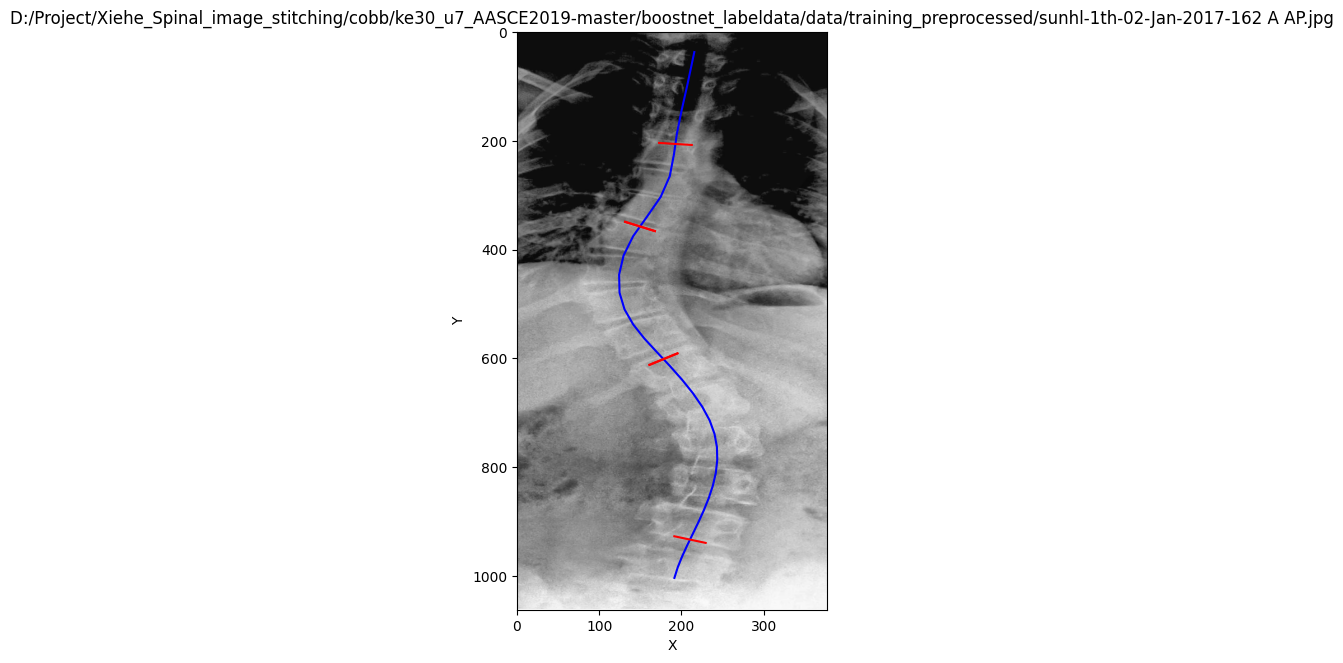

In [4]:

def calculate_slopes(points):
    # 计算每对相邻点之间的斜率
    slopes = []
    for i in range(len(points) - 1):
        y1, x1 = points[i]
        y2, x2 = points[i + 1]
        # 计算斜率
        if x2 - x1 == 0:
            print("Warning: Vertical line detected, skipped")
            continue
        slope = (y2 - y1) / (x2 - x1)
       
        slopes.append(slope)
    return slopes

slopes=np.array(calculate_slopes(y_c))
avg_slopes=[-1/s for s in slopes]

max_slope = np.amax(avg_slopes)
min_slope= np.amin(avg_slopes)
if np.argmax(avg_slopes)> np.argmin(avg_slopes):#两种情况：左弯或者右弯
    lower_MT= np.argmax(avg_slopes)
    upper_MT = np.argmin(avg_slopes)
else:
    upper_MT= np.argmax(avg_slopes)#斜率为正在上脊柱
    lower_MT = np.argmin(avg_slopes)#斜率为负在下脊柱,注意纵坐标是相反的
def find_line(y_c,upper,lower):
    mink1_x=[y_c[upper][1],y_c[upper+1][1]]
    mink1_y=[y_c[upper][0],y_c[upper+1][0]]
    maxk1_x=[y_c[lower][1],y_c[lower+1][1]]
    maxk1_y=[y_c[lower][0],y_c[lower+1][0]]
    mink1, mink2 =[mink1_x[0],mink1_y[0]], [mink1_x[1],mink1_y[1]]
    maxk1, maxk2 =[maxk1_x[0],maxk1_y[0]], [maxk1_x[1],maxk1_y[1]]
    return mink1, mink2, maxk1, maxk2
mink1, mink2, maxk1, maxk2 = find_line(y_c,upper_MT,lower_MT)

upper_max_slope= np.amax(avg_slopes[0:upper_MT+1])
upper_maxId= np.argmax(avg_slopes[0:upper_MT+1])
upper_min_slope = np.amin(avg_slopes[0:upper_MT+1])
upper_minId = np.argmin(avg_slopes[0:upper_MT+1])

lower_max_slope=np.amax(avg_slopes[lower_MT:])
lower_maxId=np.argmax(avg_slopes[lower_MT:])+lower_MT
lower_min_slope = np.amin(avg_slopes[lower_MT:])
lower_minId = np.argmin(avg_slopes[lower_MT:])+lower_MT 
mink1_upper, mink2_upper,maxk1_upper, maxk2_upper = find_line(y_c,upper_maxId,upper_minId)
mink1_lower, mink2_lower,maxk1_lower, maxk2_lower = find_line(y_c,lower_maxId,lower_minId)

cobb_angles_BS= [0.0,0.0,0.0]  
cobb_angles_BS[0]= abs(np.rad2deg(np.arctan(max_slope))- np.rad2deg(np.arctan(min_slope)))
cobb_angles_BS[1]= abs(np.rad2deg(np.arctan(upper_max_slope))-np.rad2deg(np.arctan(upper_min_slope)))
cobb_angles_BS[2]= abs(np.rad2deg(np.arctan(lower_max_slope)) - np.rad2deg(np.arctan(lower_min_slope)))
intersection = line_intersection(maxk1,maxk2,mink1,mink2)
intersection_upper = line_intersection(mink1_upper, mink2_upper,maxk1_upper, maxk2_upper)
intersection_lower = line_intersection(mink1_lower, mink2_lower,maxk1_lower, maxk2_lower)
#MT
mink_c=[(mink1[0]+mink2[0])/2,(mink1[1]+mink2[1])/2]
maxk_c=[(maxk1[0]+maxk2[0])/2,(maxk1[1]+maxk2[1])/2]#计算中点
intersection_c= find_intersection([mink1,mink2],[maxk1,maxk2])#中垂线交点
p_line1, p_line2 = calculate_perpendicular_lines([mink1,mink2],[maxk1,maxk2], 20)#中垂线

##upper
mink_c_upper=[(mink1_upper[0]+mink2_upper[0])/2,(mink1_upper[1]+mink2_upper[1])/2]
maxk_c_upper=[(maxk1_upper[0]+maxk2_upper[0])/2,(maxk1_upper[1]+maxk2_upper[1])/2]#计算中点
intersection_c_upper= find_intersection([mink1_upper,mink2_upper],[maxk1_upper,maxk2_upper])#中垂线交点
p_line1_upper, p_line2_upper = calculate_perpendicular_lines([mink1_upper,mink2_upper],[maxk1_upper,maxk2_upper], 20)#中垂线
##lower
mink_c_lower=[(mink1_lower[0]+mink2_lower[0])/2,(mink1_lower[1]+mink2_lower[1])/2]
maxk_c_lower=[(maxk1_lower[0]+maxk2_lower[0])/2,(maxk1_lower[1]+maxk2_lower[1])/2]#计算中点
intersection_c_lower= find_intersection([mink1_lower,mink2_lower],[maxk1_lower,maxk2_lower])#中垂线交点
p_line1_lower, p_line2_lower = calculate_perpendicular_lines([mink1_lower,mink2_lower],[maxk1_lower,maxk2_lower], 20)#中垂线
print (" Cobb angles", cobb_angles_BS)


fig = plt.figure(figsize=(4,7.5))
ax = fig.add_subplot(111)
# 绘制两对点到交点的延长线
ax.imshow(img, aspect='auto', alpha=1)
# ax.plot([c_lines[upper_minId][0][0],c_lines[upper_minId][1][0]],[c_lines[upper_minId][0][1],c_lines[upper_minId][1][1]],color='y')
# ax.plot([c_lines[upper_maxId][0][0],c_lines[upper_maxId][1][0]],[c_lines[upper_maxId][0][1],c_lines[upper_maxId][1][1]],color='y')
# ax.plot([c_lines[lower_minId][0][0],c_lines[lower_minId][1][0]],[c_lines[lower_minId][0][1],c_lines[lower_minId][1][1]],color='y')
# ax.plot([c_lines[lower_maxId][0][0],c_lines[lower_maxId][1][0]],[c_lines[lower_maxId][0][1],c_lines[lower_maxId][1][1]],color='y')
# 设置图形属性
# ax.scatter(xs,ys)#输入点
ax.plot(y_c[:,1],y_c[:,0],'-b')#B样条曲线
# ax.plot(cp[:,1],cp[:,0],'b*')#输出拟合的控制点坐标
##center
ax.plot([p_line1[0][0],p_line1[1][0]],[p_line1[0][1],p_line1[1][1]],color='r')
ax.plot([p_line2[0][0],p_line2[1][0]],[p_line2[0][1],p_line2[1][1]],color='r')#最大斜率椎体
ax.scatter(*intersection_c, color='blue', label='Intersection')
##upper
ax.plot([p_line1_upper[0][0],p_line1_upper[1][0]],[p_line1_upper[0][1],p_line1_upper[1][1]],color='r')
ax.plot([p_line2_upper[0][0],p_line2_upper[1][0]],[p_line2_upper[0][1],p_line2_upper[1][1]],color='r')#最大斜率椎体
ax.scatter(*intersection_c_upper, color='blue', label='Intersection')
##lower
ax.plot([p_line1_lower[0][0],p_line1_lower[1][0]],[p_line1_lower[0][1],p_line1_lower[1][1]],color='r')
ax.plot([p_line2_lower[0][0],p_line2_lower[1][0]],[p_line2_lower[0][1],p_line2_lower[1][1]],color='r')#最大斜率椎体
ax.scatter(*intersection_c_lower, color='blue', label='Intersection')

ax.set_xlabel('X')
ax.set_ylabel('Y')

ax.set_xlim(0, img.shape[1]) 
ax.set_ylim(img.shape[0] ,0 )  

ax.set_title(names[idx])
# ax.invert_yaxis()
# ax.grid(True)
plt.show()



#### 通过预测的关键点，再通过B样条曲线插值，计算COBB角度

In [5]:
import os
from utils import keyP
pred_heatmap_path =r'D:\Project\Xiehe_Spinal_image_stitching\cobb\Heatmap\pred_training_cp'
# pred_heatmap_path =r'D:\Project\Xiehe_Spinal_image_stitching\cobb\Heatmap\pred_test_cp_full'
heatmaps = os.listdir(pred_heatmap_path)
heatmap_path = os.path.join(pred_heatmap_path,heatmaps[idx])
heatmap = cv2.imread(heatmap_path, 0)
heatmap_resize = cv2.resize(heatmap,(int(heatmap.shape[1]/2),int(heatmap.shape[0]/2)))
centers = keyP(heatmap_resize)  #热图关键点

heatmap_y = [coord[0] for coord in centers]
heatmap_x = [coord[1] for coord in centers]

yy = heatmap_y
xx = heatmap_x
bs=BS_curve(9,3)#10个控制点，3次B样条

data = np.array([yy,xx]).T#
paras = bs.estimate_parameters(data)
knots = bs.get_knots()
if bs.check():
    cp = bs.approximation(data)

uq = np.linspace(0,1,34)
y_c = bs.bs(uq)
cobb_angles_heatmap_BS = cobb_angle_line(y_c)
print(cobb_angles_heatmap_BS)

[57.46358055126903, 19.985397842463392, 49.80015251140465]


#### 这里写torch版本的cobb计算

In [6]:
import torch
from B_spline_torch import BS_curve_torch
from utils import cobb_angle_line_torch
device = "cuda:0" if torch.cuda.is_available() else 'cpu'
data_tensor = torch.tensor(data).unsqueeze(0).to(device)[0]
bs_torch = BS_curve_torch(9, 3, device)
paras = bs_torch.estimate_parameters(data_tensor)
knots = bs_torch.get_knots()

cp = bs_torch.approximation(data_tensor)
uq = torch.linspace(0,1,34)
y_c_torch = bs_torch.bs(uq)
cobb_angle_torch = cobb_angle_line_torch(y_c_torch)
print(cobb_angle_torch)

tensor([56.2754, 18.7310, 48.0236])


In [6]:
print(data_tensor)

NameError: name 'data_tensor' is not defined

 Cobb angles [40.884514307973944, 18.512420080759714, 22.11110698477089]


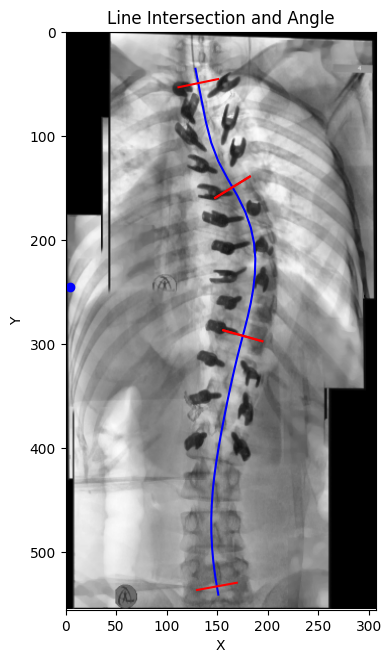

In [ ]:
from utils import line_intersection, find_intersection, calculate_perpendicular_lines
intersection = line_intersection(maxk1,maxk2,mink1,mink2)
intersection_upper = line_intersection(mink1_upper, mink2_upper,maxk1_upper, maxk2_upper)
intersection_lower = line_intersection(mink1_lower, mink2_lower,maxk1_lower, maxk2_lower)
#MT
mink_c=[(mink1[0]+mink2[0])/2,(mink1[1]+mink2[1])/2]
maxk_c=[(maxk1[0]+maxk2[0])/2,(maxk1[1]+maxk2[1])/2]#计算中点
intersection_c= find_intersection([mink1,mink2],[maxk1,maxk2])#中垂线交点
p_line1, p_line2 = calculate_perpendicular_lines([mink1,mink2],[maxk1,maxk2], 20)#中垂线

##upper
mink_c_upper=[(mink1_upper[0]+mink2_upper[0])/2,(mink1_upper[1]+mink2_upper[1])/2]
maxk_c_upper=[(maxk1_upper[0]+maxk2_upper[0])/2,(maxk1_upper[1]+maxk2_upper[1])/2]#计算中点
intersection_c_upper= find_intersection([mink1_upper,mink2_upper],[maxk1_upper,maxk2_upper])#中垂线交点
p_line1_upper, p_line2_upper = calculate_perpendicular_lines([mink1_upper,mink2_upper],[maxk1_upper,maxk2_upper], 20)#中垂线
##lower
mink_c_lower=[(mink1_lower[0]+mink2_lower[0])/2,(mink1_lower[1]+mink2_lower[1])/2]
maxk_c_lower=[(maxk1_lower[0]+maxk2_lower[0])/2,(maxk1_lower[1]+maxk2_lower[1])/2]#计算中点
intersection_c_lower= find_intersection([mink1_lower,mink2_lower],[maxk1_lower,maxk2_lower])#中垂线交点
p_line1_lower, p_line2_lower = calculate_perpendicular_lines([mink1_lower,mink2_lower],[maxk1_lower,maxk2_lower], 20)#中垂线
print (" Cobb angles", cobb_angles)


fig = plt.figure(figsize=(4,7.5))
ax = fig.add_subplot(111)
# 绘制两对点到交点的延长线
ax.imshow(img, aspect='auto', alpha=1)
# 设置图形属性
# ax.scatter(xx,yy)
# ax.scatter(maxk1_x,maxk1_y,color='blue')#画的是（x,y）,两边点
# ax.scatter(mink1_x,mink1_y,color='green')
ax.plot(y_c[:,1],y_c[:,0],'-b')#B样条曲线
# ax.plot(cp[:,1],cp[:,0],'b*')#输出拟合的控制点坐标
##center
# ax.plot([mink_c[0],intersection_c[0]],[mink_c[1],intersection_c[1]],color='r')
# ax.plot([maxk_c[0],intersection_c[0]],[maxk_c[1],intersection_c[1]],color='r')#延长交线到交点
ax.plot([p_line1[0][0],p_line1[1][0]],[p_line1[0][1],p_line1[1][1]],color='r')
ax.plot([p_line2[0][0],p_line2[1][0]],[p_line2[0][1],p_line2[1][1]],color='r')#最大斜率椎体
ax.scatter(*intersection_c, color='blue', label='Intersection')
##upper
# ax.plot([mink_c_upper[0],intersection_c_upper[0]],[mink_c_upper[1],intersection_c_upper[1]],color='r')
# ax.plot([maxk_c_upper[0],intersection_c_upper[0]],[maxk_c_upper[1],intersection_c_upper[1]],color='r')#最大斜率椎体
ax.plot([p_line1_upper[0][0],p_line1_upper[1][0]],[p_line1_upper[0][1],p_line1_upper[1][1]],color='r')
ax.plot([p_line2_upper[0][0],p_line2_upper[1][0]],[p_line2_upper[0][1],p_line2_upper[1][1]],color='r')#最大斜率椎体
ax.scatter(*intersection_c_upper, color='blue', label='Intersection')
##lower
# ax.plot([mink_c_lower[0],intersection_c_lower[0]],[mink_c_lower[1],intersection_c_lower[1]],color='r')
# ax.plot([maxk_c_lower[0],intersection_c_lower[0]],[maxk_c_lower[1],intersection_c_lower[1]],color='r')#最大斜率椎体
ax.plot([p_line1_lower[0][0],p_line1_lower[1][0]],[p_line1_lower[0][1],p_line1_lower[1][1]],color='r')
ax.plot([p_line2_lower[0][0],p_line2_lower[1][0]],[p_line2_lower[0][1],p_line2_lower[1][1]],color='r')#最大斜率椎体
ax.scatter(*intersection_c_lower, color='blue', label='Intersection')

ax.set_xlabel('X')
ax.set_ylabel('Y')

ax.set_xlim(0, img.shape[1]) 
ax.set_ylim(img.shape[0] ,0 )  

ax.set_title('Line Intersection and Angle')
# ax.invert_yaxis()
# ax.grid(True)
plt.show()
